In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
train = pd.read_json("train.json")

In [3]:
train["num_photos"] = train["photos"].apply(len)
train["num_features"] = train["features"].apply(len)
train["num_description_words"] = train["description"].apply(lambda x: len(x.split(" ")))
train["created"] = pd.to_datetime(train["created"])
train["created_year"] = train["created"].dt.year
train["created_month"] = train["created"].dt.month
train["created_day"] = train["created"].dt.day
train["created_hour"] = train['created'].dt.hour

In [4]:
train['no_fee'] = [1 if ("No Fee" in x) else(0) for x in train.features]

In [5]:
X = train.loc[:, train.columns != 'interest_level']
y = train["interest_level"]

In [6]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['manager_id'].values))

train['manager_id'] = lbl.transform(list(train['manager_id'].values))

temp = pd.concat([train.manager_id,pd.get_dummies(train.interest_level)], axis = 1).groupby('manager_id').mean()
temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = train.groupby('manager_id').count().iloc[:,1]
temp['manager_skill'] = temp['medium_frac'] + 2 * temp['high_frac'] + 1.5 * temp['high_frac']*temp['medium_frac']
# get ixes for unranked managers...
unranked_managers_ixes = temp['count']<20
# ... and ranked ones
ranked_managers_ixes = ~unranked_managers_ixes
mean_values = temp.loc[ranked_managers_ixes, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
temp.loc[unranked_managers_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
train = train.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')

In [33]:
num_feats = ["bedrooms", "latitude", "longitude", "price", "no_fee", "count",
             "num_photos", "num_features", 'created_hour', 'manager_skill']

num_feats2 = ["bedrooms", "latitude", "longitude", "price", "no_fee",
             "num_photos", "num_features", 'created_hour', 'manager_skill']

num_feats3 = ["bedrooms", "latitude", "longitude", "price", "no_fee", "count",
             "num_photos", "num_features", 'created_hour', 'manager_skill']

num_feats4 = ["bedrooms", "latitude", "longitude", "price", "no_fee", "count",
             "num_photos", "num_features", 'created_hour', 'manager_skill']

num_feats5 = ["bedrooms", "latitude", "longitude", "price", "num_photos", "num_features",
              'created_hour', 'num_description_words', 'created_day']

In [34]:
X_df = train[num_feats]
X_mat = X_df.as_matrix()
X_mat.shape

X_df2 = train[num_feats2]
X_mat2 = X_df2.as_matrix()

X_df3 = train[num_feats3]
X_mat3 = X_df3.as_matrix()

X_df4 = train[num_feats4]
X_mat4 = X_df4.as_matrix()

X_df5 = train[num_feats5]
X_mat5 = X_df5.as_matrix()
X_mat.shape

(49352, 10)

In [35]:
Y_df = pd.DataFrame(y)
Y_df['interest'] = [0 if x=='low' else(1 if x=='medium' else(2)) for x in Y_df.interest_level]
Y_mat = Y_df.interest.as_matrix()
Y_mat.shape

(49352,)

### Random Forest Feature Selection

In [10]:
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import log_loss

rf_feat_select = ensemble.RandomForestClassifier(n_estimators = 800, n_jobs = 3)


In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_mat, Y_mat, test_size=0.25)
rf_feat_select.fit(X_train, y_train)
rf_feat_select.score(X_train, y_train)

0.9905171016372184

In [22]:
y_val_pred = rf_feat_select.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.58423732939392781

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_mat2, Y_mat, test_size=0.25)
rf_feat_select.fit(X_train, y_train)
rf_feat_select.score(X_train, y_train)

0.99054411844167067

In [24]:
y_val_pred = rf_feat_select.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.59314004539544563

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_mat3, Y_mat, test_size=0.25)
rf_feat_select.fit(X_train, y_train)
rf_feat_select.score(X_train, y_train)

0.9906792024639326

In [26]:
y_val_pred = rf_feat_select.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.58702213779778833

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_mat4, Y_mat, test_size=0.25)
rf_feat_select.fit(X_train, y_train)
rf_feat_select.score(X_train, y_train)

0.99157075701086073

In [28]:
y_val_pred = rf_feat_select.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.5947006633860864

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_mat5, Y_mat, test_size=0.25)
rf_feat_select.fit(X_train, y_train)
rf_feat_select.score(X_train, y_train)

0.99910844545307176

In [30]:
y_val_pred = rf_feat_select.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.61662342667244874

In [31]:
rf_feat_select.feature_importances_

array([ 0.04658681,  0.13442586,  0.13280564,  0.18618311,  0.08251175,
        0.08393405,  0.08781776,  0.13375228,  0.11198275])

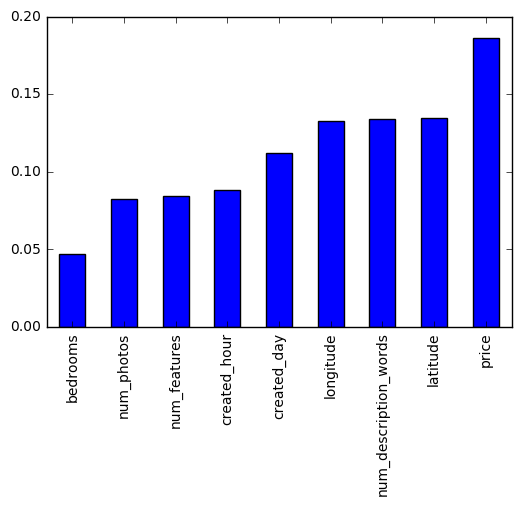

In [32]:
pd.Series(index = num_feats5, data = rf_feat_select.feature_importances_).sort_values().plot(kind = 'bar')

In [36]:
from sklearn import ensemble
from sklearn.metrics import log_loss
rf_model = ensemble.RandomForestClassifier(n_estimators = 650, n_jobs = 3)
rf_model.fit(X_mat, Y_mat)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=650, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [37]:
import sklearn.grid_search as gs
grid_para_rf = [{'max_features':[4], 'min_samples_split': [13,15,17], 'min_samples_leaf': [1,2], 
                'criterion': ['gini', 'entropy']}]

/home/andrew/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/andrew/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [38]:
grid_search_rf = gs.GridSearchCV(rf_feat_select, grid_para_rf, scoring = 'accuracy', cv=3)

In [39]:
grid_search_rf.fit(X_mat, Y_mat)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/andrew/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/andrew/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/andrew/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/andrew/anaconda2/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/andrew/anaconda2/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/andrew/anaconda2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File

IndexError: string index out of range

In [216]:
grid_search_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=700, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [217]:
grid_search_rf.best_params_

{'criterion': 'entropy',
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 15}

In [218]:
grid_search_rf.best_score_

0.7442859458583239

In [219]:
grid_search_rf.grid_scores_

[mean: 0.74305, std: 0.00207, params: {'max_features': 3, 'min_samples_split': 10, 'criterion': 'gini', 'min_samples_leaf': 1},
 mean: 0.74356, std: 0.00276, params: {'max_features': 3, 'min_samples_split': 15, 'criterion': 'gini', 'min_samples_leaf': 1},
 mean: 0.74275, std: 0.00289, params: {'max_features': 3, 'min_samples_split': 20, 'criterion': 'gini', 'min_samples_leaf': 1},
 mean: 0.74137, std: 0.00304, params: {'max_features': 3, 'min_samples_split': 25, 'criterion': 'gini', 'min_samples_leaf': 1},
 mean: 0.73995, std: 0.00281, params: {'max_features': 3, 'min_samples_split': 10, 'criterion': 'gini', 'min_samples_leaf': 10},
 mean: 0.73983, std: 0.00322, params: {'max_features': 3, 'min_samples_split': 15, 'criterion': 'gini', 'min_samples_leaf': 10},
 mean: 0.74019, std: 0.00313, params: {'max_features': 3, 'min_samples_split': 20, 'criterion': 'gini', 'min_samples_leaf': 10},
 mean: 0.73938, std: 0.00317, params: {'max_features': 3, 'min_samples_split': 25, 'criterion': 'gini

In [12]:
rf_gs_model = ensemble.RandomForestClassifier(n_estimators = 1000, n_jobs = 2, criterion = 'entropy', \
                                               min_samples_split = 15, max_features = 4)

In [13]:
rf_gs_model.fit(X_mat, Y_mat)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=2, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [14]:
rf_gs_model.score(X_mat, Y_mat)

0.89110876965472519

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_mat, Y_mat, test_size=0.25)

In [16]:
rf_gs_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=2, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [17]:
y_val_pred = rf_gs_model.predict_proba(X_val)

In [18]:
log_loss(y_val, y_val_pred)

0.56373237120175856

#### look for optimal samples to split by...

In [ ]:
samples_tester = []

for x in range(1, 6, 1):
    if x % 2 == 0:
        print("Checking model with %d leafmin") % (x)
    clf = ensemble.RandomForestClassifier(n_estimators=625, n_jobs=3, min_samples_split = 10, min_samples_leaf = x, oob_score=True)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict_proba(X_val)
    ll = log_loss(y_val, y_val_pred)
    samples_tester.append([x, ll, clf.oob_score_])

In [ ]:
tree = []
logloss = []
oob = []
for x in samples_tester:
    tree.append(x[0])
    logloss.append(x[1])
    oob.append(x[2])

In [ ]:
plt.scatter(tree, logloss)
plt.plot(tree, logloss)
plt.ylabel('logloss')
plt.xlabel('min sample split')
plt.title('logloss vs min sample split')
plt.show()

In [ ]:
plt.scatter(tree, oob)
plt.plot(tree, oob)
plt.ylabel('oob score')
plt.xlabel('min sample split')
plt.title('oob vs min sample split')
plt.show()

#### Search for optimal # of trees

In [ ]:
LL_tree = []

In [ ]:
for x in range(300, 1001, 100):
    if x % 200 == 0:
        print("Checking model with %d ests") % (x)
    clf = ensemble.RandomForestClassifier(n_estimators=x, n_jobs=3, oob_score=True)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict_proba(X_val)
    ll = log_loss(y_val, y_val_pred)
    LL_tree.append([x, ll, clf.oob_score_])

In [ ]:
tree = []
logloss = []
oob = []
for x in LL_tree:
    tree.append(x[0])
    logloss.append(x[1])
    oob.append(x[2])

In [ ]:
plt.scatter(tree, logloss)
plt.plot(tree, logloss)
plt.ylabel('logloss')
plt.xlabel('tree count')
plt.title('logloss vs # of trees')
plt.show()

In [ ]:
plt.scatter(tree, oob)
plt.plot(tree, oob)
plt.ylabel('oob score')
plt.xlabel('tree count')
plt.title('oob vs # of trees')
plt.show()

#### Adapt Predictions

In [92]:
test = pd.read_json(open("test.json", "r"))
print(test.shape)

(74659, 14)


In [93]:
test["num_photos"] = test["photos"].apply(len)
test["num_features"] = test["features"].apply(len)
test["num_description_words"] = test["description"].apply(lambda x: len(x.split(" ")))
test["created"] = pd.to_datetime(test["created"])
test["created_year"] = test["created"].dt.year
test["created_month"] = test["created"].dt.month
test["created_day"] = test["created"].dt.day
test["created_hour"] = test['created'].dt.hour

In [94]:
test['no_fee'] = [1 if ("No Fee" in x) else(0) for x in test.features]

In [96]:
# add the features computed on the training dataset to the validation dataset
test = test.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = test['high_frac'].isnull()
test.loc[new_manager_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
test.columns

Index([            u'bathrooms',              u'bedrooms',
                 u'building_id',               u'created',
                 u'description',       u'display_address',
                    u'features',              u'latitude',
                  u'listing_id',             u'longitude',
                  u'manager_id',                u'photos',
                       u'price',        u'street_address',
                  u'num_photos',          u'num_features',
       u'num_description_words',          u'created_year',
               u'created_month',           u'created_day',
                u'created_hour',                u'no_fee',
                   u'high_frac',              u'low_frac',
                 u'medium_frac',         u'manager_skill'],
      dtype='object')

In [100]:
add_count = test.groupby('manager_id').count().iloc[:,1]
add_count = pd.DataFrame(add_count)
add_count['count'] = add_count.bedrooms
del add_count['bedrooms']

In [101]:
test = test.merge(add_count,how='left', left_on='manager_id', right_index=True)

In [103]:
test.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,created_year,created_month,created_day,created_hour,no_fee,high_frac,low_frac,medium_frac,manager_skill,count
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,...,2016,6,11,5,0,0.081314,0.673194,0.245492,0.449945,38
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,...,2016,6,24,6,0,0.081314,0.673194,0.245492,0.449945,17
2,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,...,2016,6,3,4,1,0.081314,0.673194,0.245492,0.449945,4
3,1.0,2,783d21d013a7e655bddc4ed0d461cc5e,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,South Third Street\r,"[Roof Deck, Balcony, Elevator, Laundry in Buil...",40.7109,7143442,-73.9571,...,2016,6,11,6,0,0.081314,0.673194,0.245492,0.449945,117
4,2.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...","Midtown West, 8th Ave","[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.7650,6860601,-73.9845,...,2016,4,12,5,1,0.081314,0.673194,0.245492,0.449945,96


In [104]:
testclf = ensemble.RandomForestClassifier(n_estimators=2000, n_jobs = 3, min_samples_split = 15, max_features = 4, 
                                         criterion = 'entropy')

In [105]:
testclf.fit(X_mat, Y_mat)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [106]:
X = test[num_feats]
y = testclf.predict_proba(X)

In [107]:
labels2idx = {'low': 0, 'medium': 1, 'high': 2}
labels2idx

{'high': 2, 'low': 0, 'medium': 1}

In [108]:
sub = pd.DataFrame()
sub["listing_id"] = test["listing_id"]
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]
sub.to_csv("submission_rf.csv", index=False)

array([[ 0.61853827,  0.34241511,  0.03904662],
       [ 0.21830015,  0.39347958,  0.38822028],
       [ 0.94287482,  0.04826271,  0.00886248],
       ..., 
       [ 0.7645825 ,  0.21157613,  0.02384137],
       [ 0.38777055,  0.35275871,  0.25947074],
       [ 0.71691452,  0.22307621,  0.06000928]])